#Stratégie adoptée

Obtenir des prédictions satisfaisantes avec ce dataset relève du défi. Si nous disposions d'une ferme de serveurs, nous pourrions utiliser RFECV pour sélectionner automatiquement les meilleures features. A défaut, nous allons tenter une stratégie moins gourmande :

1. Features importance

XGBoostRegressor va fournir une liste de features par ordre décroissant.



2. Forward selection

L'algorithme sera plus économe en ressources que RFECV parce qu'on intègrera au fur et à mesure les features les plus importantes, jusqu'à ce que le score n'augmente plus.

#1.Installation des librairies

Cette librairie, créée par les développeurs de scikit-learn, nous permettra d'effectuer une recherche d'optimisation bayésienne sur l'espace des hyperparamètres.
https://scikit-optimize.github.io/stable/modules/generated/skopt.BayesSearchCV.html

In [ ]:
!pip install scikit-optimize

##1.2GLMM encoding

Dans leur papier, The scikit-learn library only provides a Target Encoder.
" [...] GLMMs are a major workhorse in applied statistics but not well understood and often neglected by the ML community."
Nous allons utiliser l'implémentation fournie par

In [ ]:
# the GLMM encoder
!pip install --upgrade category_encoders

##1.3Count Encoder

A la place du OneHotEncoding, nous allons utiliser un encoder qui a deux avantages:
- Il nous permet de conserver les informations concernant la distribution des catégories, car elles sont remplacées par leur occurrence au lieu d'un simple 1 ou 0.
- Il ne crée pas de colonnes supplémentaires, ce qui va nous faire grandement gagner en performance.
The implementation provided by category_encoders doesn't support multiple targets, so we use the one from feature-engine.
https://feature-engine.trainindata.com/en/latest/api_doc/encoding/CountFrequencyEncoder.html

Par contre, il a un désavantage : si une catégorie figure uniquement dans le test set, il ne connaîtra pas sa fréquence, donc il va créer des valeurs manquantes. Pour éviter ce cas de figure, nous allons regrouper les catégories rares
https://feature-engine.trainindata.com/en/latest/api_doc/encoding/RareLabelEncoder.html

In [ ]:
!pip install feature-engine

#2.Chargement des librairies

In [ ]:
# System
import os
from joblib import dump, load
from google.colab import files
import warnings

# Data
import pandas as pd
import numpy as np
import math
from scipy.stats import randint, uniform, loguniform

# Graphics
import matplotlib.pyplot as plt

# Machine learning - Preprocessing
import sklearn
from sklearn.impute import KNNImputer, SimpleImputer
from sklearn.preprocessing import OneHotEncoder, QuantileTransformer, PowerTransformer, FunctionTransformer, OrdinalEncoder, StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.base import BaseEstimator, TransformerMixin
from category_encoders.glmm import GLMMEncoder
from feature_engine.encoding import CountFrequencyEncoder, RareLabelEncoder

# Machine learning - Automatisation
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn import set_config
from sklearn.dummy import DummyRegressor

# Machine learning - Metrics
from sklearn.metrics import r2_score, mean_absolute_error

# Machine learning - Models
import xgboost as xgb
from lightgbm import LGBMRegressor
from sklearn.cluster import KMeans
from sklearn.linear_model import HuberRegressor, TheilSenRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor, RandomForestRegressor, AdaBoostRegressor
from sklearn.multioutput import RegressorChain

# Machine learning - Model selection
from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import train_test_split, LearningCurveDisplay, ShuffleSplit, HalvingRandomSearchCV
from skopt import BayesSearchCV
from skopt.space import Real, Integer, Categorical
from sklearn.exceptions import NotFittedError

#
from sklearn.feature_selection import RFECV

#3.Configuration

In [ ]:
# Silence warnings
# warnings.filterwarnings("ignore", category=UserWarning)

In [ ]:
# Mount GoogleDrive and set the files path
from google.colab import drive
drive.mount('/content/drive')
%cd '/content/drive/MyDrive/CO2'
path = os.getcwd()
print(f"Le répertoire courant est : {path} \n")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/CO2
Le répertoire courant est : /content/drive/MyDrive/CO2 



#3.Chargement du dataset

In [ ]:
df = pd.read_csv('co2_eda.csv')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3299 entries, 0 to 3298
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   buildingtype                   3299 non-null   object 
 1   primarypropertytype            3299 non-null   object 
 2   taxparcelidentificationnumber  3299 non-null   object 
 3   councildistrictcode            3299 non-null   int64  
 4   neighborhood                   3299 non-null   object 
 5   numberofbuildings              3299 non-null   int64  
 6   numberoffloors                 3299 non-null   int64  
 7   propertygfatotal               3299 non-null   int64  
 8   propertygfaparking             3299 non-null   int64  
 9   propertygfabuilding            3299 non-null   int64  
 10  listofallpropertyusetypes      3299 non-null   object 
 11  largestpropertyusetype         3288 non-null   object 
 12  largestpropertyusetypegfa      3288 non-null   f

In [ ]:
# Fix dtype changes after CSV exporting
df['energystarscore'] = df['energystarscore'].astype('object')
df['councildistrictcode'] = df['councildistrictcode'].astype('object')
# Turn the boolean columns into categorical for target encoding
# for column in df.select_dtypes(include=['bool']).columns:
#   df[column] = df[column].astype('object')
df.dtypes

buildingtype                      object
primarypropertytype               object
taxparcelidentificationnumber     object
councildistrictcode               object
neighborhood                      object
numberofbuildings                  int64
numberoffloors                     int64
propertygfatotal                   int64
propertygfaparking                 int64
propertygfabuilding                int64
listofallpropertyusetypes         object
largestpropertyusetype            object
largestpropertyusetypegfa        float64
energystarscore                   object
siteeuiwn_kbtu_sf                float64
sourceeuiwn_kbtu_sf              float64
siteenergyuse_kbtu               float64
siteenergyusewn_kbtu             float64
steam                               bool
electricity                         bool
naturalgas                          bool
defaultdata                         bool
compliancestatus                  object
totalghgemissions                float64
zipcode         

Après avoir tenté toutes sortes d'options pour imputer les données manquantes (SimpleImputer, KNN, native XGBoost...), la méthode la plus simple s'avère la plus efficace :

In [ ]:
df.dropna(inplace=True)

#4.Gestion des targets multiples

Scikit-learn propose deux solutions :
- MultiOutputRegressor si les variables sont traitées de façon indépendante.
- RegressorChain si elles sont dépendantes.

https://scikit-learn.org/stable/modules/multiclass.html

Il y a une corrélation élevée (0.873) entre la consommation énergétique et les émissions de CO2, donc on choisira la seconde option.

Comme nous prédirons les émissions après la consommation, cela nous mène à créer une variable targets commençant par la colonne siteenergyuse_kbtu :

In [ ]:
# Define the targets and features
targets = ['sourceeuiwn_kbtu_sf', 'source_wn', 'siteeuiwn_kbtu_sf', 'site_wn', 'source_site', 'siteenergyusewn_kbtu', 'siteenergyuse_kbtu', 'totalghgemissions']
y = df[targets]
X = df.drop(targets, axis=1)

In [ ]:
X.select_dtypes(include=['int64', 'float64']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   numberofbuildings          2489 non-null   int64  
 1   numberoffloors             2489 non-null   int64  
 2   propertygfatotal           2489 non-null   int64  
 3   propertygfaparking         2489 non-null   int64  
 4   propertygfabuilding        2489 non-null   int64  
 5   largestpropertyusetypegfa  2489 non-null   float64
 6   zipcode                    2489 non-null   float64
 7   latitude                   2489 non-null   float64
 8   longitude                  2489 non-null   float64
 9   age                        2489 non-null   int64  
dtypes: float64(4), int64(6)
memory usage: 213.9 KB


In [ ]:
X.select_dtypes(include=['object', 'bool']).info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 12 columns):
 #   Column                     Non-Null Count  Dtype 
---  ------                     --------------  ----- 
 0   buildingtype               2489 non-null   object
 1   primarypropertytype        2489 non-null   object
 2   councildistrictcode        2489 non-null   object
 3   neighborhood               2489 non-null   object
 4   listofallpropertyusetypes  2489 non-null   object
 5   largestpropertyusetype     2489 non-null   object
 6   energystarscore            2489 non-null   object
 7   steam                      2489 non-null   bool  
 8   electricity                2489 non-null   bool  
 9   naturalgas                 2489 non-null   bool  
 10  defaultdata                2489 non-null   bool  
 11  compliancestatus           2489 non-null   object
dtypes: bool(4), object(8)
memory usage: 184.7+ KB


In [ ]:
categorical_columns = X.select_dtypes(include=['object', 'bool']).columns.tolist()

[]

In [ ]:
# Convert categorical features to the appropriate integer type
for column in categorical_columns:
    X[column] = X[column].astype('category').cat.codes

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   buildingtype               2489 non-null   int8   
 1   primarypropertytype        2489 non-null   int8   
 2   councildistrictcode        2489 non-null   int8   
 3   neighborhood               2489 non-null   int8   
 4   numberofbuildings          2489 non-null   int64  
 5   numberoffloors             2489 non-null   int64  
 6   propertygfatotal           2489 non-null   int64  
 7   propertygfaparking         2489 non-null   int64  
 8   propertygfabuilding        2489 non-null   int64  
 9   listofallpropertyusetypes  2489 non-null   int16  
 10  largestpropertyusetype     2489 non-null   int8   
 11  largestpropertyusetypegfa  2489 non-null   float64
 12  energystarscore            2489 non-null   int8   
 13  steam                      2489 non-null   int8 

#5.Preprocessing des données

L'EDA a montré que certaines variables étaient loin d'avoir une distribution gaussienne. Pour y remédier, le QuantileTransformer semble préférable au PowerTransformer parce qu'il est efficace quelle que soit la distribution de départ : https://scikit-learn.org/stable/modules/preprocessing.html#mapping-to-a-gaussian-distribution

In [ ]:
# Apply QuantileTransformer to the target variables
qt = PowerTransformer()
y = qt.fit_transform(y)

As we try different features for the model, the number of columns in X will vary. The following function will compute the list of columns for the numerical features and the remaining categorical feature ('listofallpropertyusetypes'), which will be treated separately with a count vectorizer.

##5.3Numerical

In [ ]:
# Preprocess the numerical features
transfo_num = Pipeline(steps=[
    ('scaling', PowerTransformer()),
    # ('scaling', QuantileTransformer(output_distribution='normal', random_state=42))
    # ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

##5.5OrdinalEncoder

In [ ]:
# Preprocess with OrdinalEncoder
transfo_ord = Pipeline(steps=[
    ('ordinal', OrdinalEncoder(handle_unknown='use_encoded_value', unknown_value=np.nan)),
    ('scaling', PowerTransformer()),
    # ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

##5.6Fisher Encoding

In [ ]:
# Preprocess with CountEncoder
transfo_fisher = Pipeline(steps=[
    ('scaling', PowerTransformer()),
    # ('imputation', SimpleImputer(strategy='constant', fill_value=-999)),
])

Avec ce type de preprocessing, seul le CountVectorizer va accroître le nombre de colonnes. Pour retrouver facilement l'ordre des features, il nous suffit donc de placer la colonne 'listofallpropertyusetypes' en dernier :

In [ ]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 22 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   buildingtype               2489 non-null   int8   
 1   primarypropertytype        2489 non-null   int8   
 2   councildistrictcode        2489 non-null   int8   
 3   neighborhood               2489 non-null   int8   
 4   numberofbuildings          2489 non-null   int64  
 5   numberoffloors             2489 non-null   int64  
 6   propertygfatotal           2489 non-null   int64  
 7   propertygfaparking         2489 non-null   int64  
 8   propertygfabuilding        2489 non-null   int64  
 9   listofallpropertyusetypes  2489 non-null   int16  
 10  largestpropertyusetype     2489 non-null   int8   
 11  largestpropertyusetypegfa  2489 non-null   float64
 12  energystarscore            2489 non-null   int8   
 13  steam                      2489 non-null   int8 

In [ ]:
# X = X[[]]

#6.Création de la pipeline

In [ ]:
# Define the different preprocessing categories
# All the categorical variables except
def get_columns(X=None):
  num = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
  ord = ['energystarscore'] if 'energystarscore' in X.columns else []
  fisher = X[categorical_columns].drop(ord, axis=1).columns.tolist()
  return num, ord, fisher

In [ ]:
def chain_pipe(model, num, transfo_num, ord, transfo_ord, fisher, transfo_fisher):
    '''Define the chain and preparation step, then concatenate'''

    preparation = ColumnTransformer(
    transformers=[
    ('num', transfo_num, num),
    ('ord', transfo_ord, ord),
    ('fisher', transfo_fisher, fisher),
    ])

    chain = RegressorChain(model, verbose=True)

    pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('chain', chain)
    ],
    verbose=True,
    memory='/content/cache_directory' # caching doesn't work with custom Classes
    )
    return pipe

#7.Choix de la métrique d'erreur

A titre de comparaison, nous conserverons le R2 score, mais c'est en minimisant la MAE que nous parviendrons à obtenir les meilleurs résultats possibles avec le fichi

In [ ]:
# Define the scoring metric
scoring='r2'
# Evaluate the model
def evaluate_model(opt=None, X=None, y=y, scoring=scoring):
  # Find the best parameters
  print('\nCV parameters:')
  for key, value in opt.best_params_.items():
    print("{}: {}".format(key, value))
  # Evaluate cross validation performance
  print('\nMean CV score (all targets):', opt.best_score_.round(4))

# Plot the learning curve
def plot_curve(opt=None, X=None, y=y, scoring=scoring):
  print('\nComputing Cross Validation for the Learning Curve...\n')
  display = LearningCurveDisplay.from_estimator(
    opt.best_estimator_,
    X,
    y,
    train_sizes=np.linspace(0.1, 1.0, num=5),
    cv=ShuffleSplit(n_splits=50, test_size=0.2, random_state=0),
    score_type="both",  # both train and test errors
    scoring=scoring,
    score_name="R2 score",
    std_display_style="fill_between",
    n_jobs=-1,
    verbose=3
    )
  _ = display.ax_.set_title('Learning Curve')

In [ ]:
def get_predictions(opt=None, X_test=None, y_test=None, targets=targets):
  # Inverse transform the values to obtain an MAE that makes sense
  y_pred = opt.predict(X_test)
  y_pred_inv = qt.inverse_transform(y_pred)
  y_test_inv = qt.inverse_transform(y_test)
  # calculate R2 and MAE for each target
  for i, target in enumerate(targets):
    r2 = r2_score(y_test[:, i], y_pred[:, i])
    mae = mean_absolute_error(y_test_inv[:, i], y_pred_inv[:, i])
    print('\n' + target)
    print("R2 score:", r2)
    print("MAE:", mae)
  return r2

#8.Recherche des hyperparamètres

In [ ]:
# # XGBoost
# xg = {
#     'preparation__vec__vectorizer__min_df': Real(1e-5, 0.5, prior='log-uniform'),
#     'preparation__count__rare__tol': Real(1e-5, 0.05, prior='log-uniform'),
#     'chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
#     'chain__base_estimator__max_depth': Integer(2, 20),
#     'chain__base_estimator__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
#     'chain__base_estimator__subsample': Real(0.1, 1.0, prior='uniform'),
#     'chain__base_estimator__colsample_bytree': Real(0.1, 1.0, prior='uniform'),
#     'chain__base_estimator__reg_alpha': Real(1e-5, 100, prior='log-uniform'),
#     'chain__base_estimator__reg_lambda': Real(1e-5, 100, prior='log-uniform'),
# }

In [ ]:
lg = {
    # 'preparation__vec__vectorizer__min_df': Real(1e-5, 0.2, prior='log-uniform'),
    'chain__base_estimator__n_estimators': Categorical(list(range(100, 1001, 50))),
    'chain__base_estimator__max_depth': Integer(2, 20),
    'chain__base_estimator__learning_rate': Real(0.01, 1.0, prior='log-uniform'),
    'chain__base_estimator__subsample': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__colsample_bytree': Real(0.1, 1.0, prior='uniform'),
    'chain__base_estimator__reg_alpha': Real(1e-5, 100, prior='log-uniform'),
    'chain__base_estimator__reg_lambda': Real(1e-5, 100, prior='log-uniform'),
    'chain__base_estimator__min_child_samples': Integer(1, 20),
    'chain__base_estimator__min_child_weight': Real(1e-5, 10, prior='log-uniform'),
    'chain__base_estimator__min_split_gain': Real(1e-5, 1.0, prior='log-uniform'),
    'chain__base_estimator__subsample_freq': Integer(0, 10),
    'chain__base_estimator__num_leaves': Integer(10, 100),
}

In [ ]:
def find_hyperparameters(model, search_space, X=None, y=y, test_size=0.2, scoring=scoring, targets=targets, transfo_num=transfo_num, transfo_ord=transfo_ord, transfo_fisher=transfo_fisher, *, plot=False, save=False):
  '''print scores and return the feature importances if needed'''
  # split into train and test sets
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=42)
  # Get the columns corresponding to the current selection of features
  num, ord, fisher = get_columns(X)
  # create the pipeline
  pipe = chain_pipe(model, num, transfo_num, ord, transfo_ord, fisher, transfo_fisher)
  # use BayesSearchCV to find optimal hyperparameters
  opt = BayesSearchCV(
    pipe,
    search_space,
    n_iter=10,
    scoring=scoring,
    cv=5,
    n_jobs=-1,
    n_points=10,
    verbose=3,
    error_score='raise',
    random_state=42
    )
  opt.fit(X_train, y_train)
  # get CV scores
  evaluate_model(opt, X)
  # get predictions
  score = get_predictions(opt, X_test, y_test, targets)
  # plot learning curve
  if plot is True:
    plot_curve(opt, X)
  # Save the best model to a file
  elif save is True:
    file_name = str(model).split('(')[0] + '_' + str(len(X_train.columns)) + 'features_lgbm.joblib'
    dump(opt.best_estimator_, file_name)
  return opt, score

##8.1 Dummy test

In [ ]:
# dr = {
#     # 'preparation__geo__clustering__n_clusters': Integer(2, 4),
#     # 'preparation__geo__clustering__kw_args': {'n_clusters': 2},
#     # 'preparation__geo__clustering__kw_args': Categorical([map_clusters(i) for i in range(2, 1003, 50)]),
#     #     'preparation__geo__clustering__kw_args': Space([
#     #     Categorical({'n_clusters': 2}),
#     #     Categorical({'n_clusters': 3})
#     # ]),
#     # 'preparation__geo__clustering__kw_args': Categorical([('n_clusters', 2), ('n_clusters', 3)]),
#     # 'preparation__geo__clustering__kw_args': Categorical({'n_clusters': 2}, {'n_clusters': 3}),
#     # 'preparation__geo__clustering__kw_args': 'n_clusters': 2},
#     # 'preparation__geo__clustering__kw_args': Categorical([map_clusters(i) for i in range(2, 1003, 50)]),
#     # 'preparation__geo__clustering__kw_args': Categorical([{'n_clusters': i} for i in range(2, 1003, 50)]),
#     'chain__base_estimator__quantile' : [0.5]
# }
# opt, score = find_hyperparameters(DummyRegressor(), dr, X)
# opt

In [ ]:
# opt.get_params()

In [ ]:
# Stop "Run All" from going beyond this cell
# assert False

##8.2 Fit the model

In [ ]:
opt, score = find_hyperparameters(LGBMRegressor(), lg, X, save=True)
opt

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


[Pipeline] ....... (step 1 of 2) Processing preparation, total=   0.1s
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000195 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 1991, number of used features: 21
[LightGBM] [Info] Start training from score -0.019380
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: 

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(



source_wn
R2 score: 0.5016995402657751
MAE: 0.018220173632433605

siteeuiwn_kbtu_sf
R2 score: 0.6624518585164769
MAE: 14.867725536472264

site_wn
R2 score: 0.48757079179161555
MAE: 0.022068671391879097

source_site
R2 score: 0.6007103915151979
MAE: 0.2552241888208054

siteenergyusewn_kbtu
R2 score: 0.870482995602538
MAE: 1608685.1501872547

siteenergyuse_kbtu
R2 score: 0.8699820860675258
MAE: 1479766.674030134

totalghgemissions
R2 score: 0.826138168676013
MAE: 55.75203639139841


BayesSearchCV(cv=5,
              estimator=Pipeline(memory='/content/cache_directory',
                                 steps=[('preparation',
                                         ColumnTransformer(transformers=[('num',
                                                                          Pipeline(steps=[('scaling',
                                                                                           PowerTransformer())]),
                                                                          ['numberofbuildings',
                                                                           'numberoffloors',
                                                                           'propertygfatotal',
                                                                           'propertygfaparking',
                                                                           'propertygfabuilding',
                                                                           'largestpropertyusetypegfa',
                                                                           'zipcode',
                                                                           'latitude',
                                                                           'longitude',
                                                                           'age'])...
                             'chain__base_estimator__reg_alpha': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                             'chain__base_estimator__reg_lambda': Real(low=1e-05, high=100, prior='log-uniform', transform='normalize'),
                             'chain__base_estimator__subsample': Real(low=0.1, high=1.0, prior='uniform', transform='normalize'),
                             'chain__base_estimator__subsample_freq': Integer(low=0, high=10, prior='uniform', transform='normalize')},
              verbose=3)

In [ ]:
# Stop "Run All" from going beyond this cell
assert False

AssertionError: ignored

#9.Sélection des Features

In [ ]:
estimators = opt.best_estimator_['chain'].estimators_
last_estimator = estimators[-1]
dump(last_estimator, 'last_estimator_lgbm.joblib')

['last_estimator_lgbm.joblib']

In [ ]:
last_estimator = load('last_estimator_lgbm.joblib')

In [ ]:
def pipe_rfe(model, num, transfo_num, ord, transfo_ord, fisher, transfo_fisher):
    '''Define the chain and preparation step, then concatenate'''

    preparation = ColumnTransformer(
    transformers=[
    ('num', transfo_num, num),
    ('ord', transfo_ord, ord),
    ('fisher', transfo_fisher, fisher),
    ])

    pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('rfe', RFECV(model, step=1, cv=5, scoring=scoring, verbose=20, n_jobs=-1))
    ],
    verbose=True,
    memory='/content/cache_directory' # caching doesn't work with custom Classes
    )
    return pipe

In [ ]:
num, ord, fisher = get_columns(X)
pipe = pipe_rfe(last_estimator, num, transfo_num, ord, transfo_ord, fisher, transfo_fisher)

In [ ]:
pipe.fit(X, y[:, -1])

Fitting estimator with 22 features.
[LightGBM] [Warning] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000253 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1871
[LightGBM] [Info] Number of data points in the train set: 2489, number of used features: 21
[LightGBM] [Info] Start training from score 0.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further

Pipeline(memory='/content/cache_directory',
         steps=[('preparation',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaling',
                                                                   PowerTransformer())]),
                                                  ['numberofbuildings',
                                                   'numberoffloors',
                                                   'propertygfatotal',
                                                   'propertygfaparking',
                                                   'propertygfabuilding',
                                                   'largestpropertyusetypegfa',
                                                   'zipcode', 'latitude',
                                                   'longitude', 'age']),
                                                 ('ord',
                                                  Pipeline(steps=[('ord...
                       estimator=LGBMRegressor(colsample_bytree=0.2602755265564576,
                                               learning_rate=0.18373473033929408,
                                               max_depth=3,
                                               min_child_samples=14,
                                               min_child_weight=0.12487730492520815,
                                               min_split_gain=0.07243293674176336,
                                               n_estimators=150, num_leaves=99,
                                               reg_alpha=0.01590649424018703,
                                               reg_lambda=1.0753488770332786e-05,
                                               subsample=0.8603729607152474,
                                               subsample_freq=7),
                       n_jobs=-1, scoring='r2', verbose=20))],
         verbose=True)

In [ ]:
# Access the RFECV estimator within the pipeline
rfecv = pipe.named_steps['rfe']

In [ ]:
dump(rfecv, 'rfecv_estimator_lgbm.joblib')

['rfecv_estimator_lgbm.joblib']

In [ ]:
rfecv = load('rfecv_estimator_lgbm.joblib')

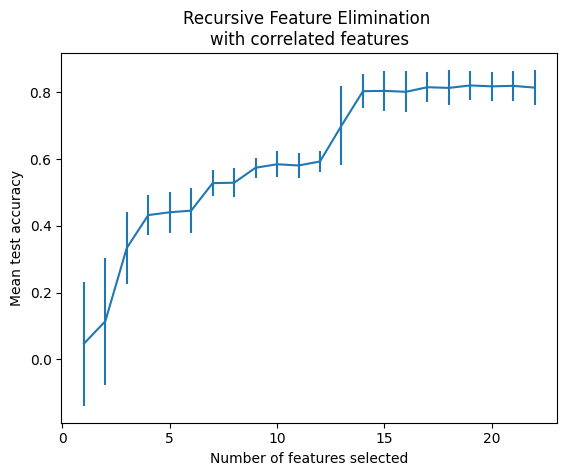

In [ ]:
import matplotlib.pyplot as plt
min_features_to_select = 1  # Minimum number of features to consider
n_scores = len(rfecv.cv_results_["mean_test_score"])
plt.figure()
plt.xlabel("Number of features selected")
plt.ylabel("Mean test accuracy")
plt.errorbar(
    range(min_features_to_select, n_scores + min_features_to_select),
    rfecv.cv_results_["mean_test_score"],
    yerr=rfecv.cv_results_["std_test_score"],
)
plt.title("Recursive Feature Elimination \nwith correlated features")
plt.show()

In [ ]:
print(f"Optimal number of features: {rfecv.n_features_}")

Optimal number of features: 19


In [ ]:
feature_names = X.columns.tolist()

In [ ]:
# get feature importances
feature_importances = zip(feature_names, rfecv.ranking_)

In [ ]:
importances = {}
for name, importance in feature_importances:
  importances[name] = importance

In [ ]:
X.shape

(2489, 22)

In [ ]:
sorted_importances = sorted(importances.items(), key=lambda x: x[1], reverse=False)
sorted_importances

[('buildingtype', 1),
 ('primarypropertytype', 1),
 ('councildistrictcode', 1),
 ('neighborhood', 1),
 ('numberofbuildings', 1),
 ('numberoffloors', 1),
 ('propertygfatotal', 1),
 ('propertygfaparking', 1),
 ('propertygfabuilding', 1),
 ('listofallpropertyusetypes', 1),
 ('largestpropertyusetype', 1),
 ('largestpropertyusetypegfa', 1),
 ('energystarscore', 1),
 ('electricity', 1),
 ('naturalgas', 1),
 ('defaultdata', 1),
 ('compliancestatus', 1),
 ('latitude', 1),
 ('longitude', 1),
 ('steam', 2),
 ('zipcode', 3),
 ('age', 4)]

In [ ]:
X.drop(['steam', 'zipcode', 'age'], axis=1, inplace=True)
X.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2489 entries, 0 to 3294
Data columns (total 19 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   buildingtype               2489 non-null   int8   
 1   primarypropertytype        2489 non-null   int8   
 2   councildistrictcode        2489 non-null   int8   
 3   neighborhood               2489 non-null   int8   
 4   numberofbuildings          2489 non-null   int64  
 5   numberoffloors             2489 non-null   int64  
 6   propertygfatotal           2489 non-null   int64  
 7   propertygfaparking         2489 non-null   int64  
 8   propertygfabuilding        2489 non-null   int64  
 9   listofallpropertyusetypes  2489 non-null   int16  
 10  largestpropertyusetype     2489 non-null   int8   
 11  largestpropertyusetypegfa  2489 non-null   float64
 12  energystarscore            2489 non-null   int8   
 13  electricity                2489 non-null   int8 

In [ ]:
categorical_columns = X.select_dtypes(include=['int8']).columns.tolist()
categorical_columns

['buildingtype',
 'primarypropertytype',
 'councildistrictcode',
 'neighborhood',
 'largestpropertyusetype',
 'energystarscore',
 'electricity',
 'naturalgas',
 'defaultdata',
 'compliancestatus']

In [ ]:
opt, score = find_hyperparameters(LGBMRegressor(), lg, X, save=True)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:236: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)
/usr/local/lib/python3.10/dist-packages/numpy/core/_methods.py:247: RuntimeWarning: overflow encountered in reduce
  ret = umr_sum(x, axis, dtype, out, keepdims=keepdims, where=where)


Streaming output truncated to the last 5000 lines.
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with posit

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but PowerTransformer was fitted with feature names
  warnings.warn(


In [ ]:
intermediate_output = pipe.named_steps['preparation'].transform(X)

In [ ]:
# Access the intermediate output after the "preprocessing" step
intermediate_output = chain_pipe.named_steps['preparation'].transform(X)

# Print the shape or any other relevant information about the intermediate output
print(intermediate_output.shape)

In [ ]:
X.info()

In [ ]:
estimators = opt.best_estimator_['chain'].estimators_
last_estimator = estimators[-1]
importances = last_estimator.feature_importances_
importances[:5]

In [ ]:
vec = ['listofallpropertyusetypes_' + x for x in list(opt.best_estimator_['preparation'].named_transformers_['vec'].named_steps['vectorizer'].vocabulary_.keys())]
len(vec)

In [ ]:
_, num, _, ord, count = get_columns(X)

In [ ]:
geo = ['geo__x0']

In [ ]:
feature_names = geo + num + vec + ord + count
len(feature_names)

In [ ]:
def get_features(opt, X=None):
  '''get feature importances once the ChainRegressor has been fit'''
  # get feature names after grid processing
  if 'latitude' or 'geo__x0' in X.columns:
    geo = ['latitude', 'longitude']
    # geo = ['geo__x0']
  else:
    geo = []
  # get feature names after CountVectorizer if the column 'listofallpropertyusetypes' was in X
  try:
    vec = ['listofallpropertyusetypes_' + x for x in list(opt.best_estimator_['preparation'].named_transformers_['vec'].named_steps['vectorizer'].vocabulary_.keys())]
  except AttributeError:
    vec = []
  # Get the column names that didn't change and sum it all
  _, num, _, ord, count = get_columns(X)
  feature_names = geo + num + vec + ord + count
  # get the best model for the last target ('totalghgemissions')
  estimators = opt.best_estimator_['chain'].estimators_
  last_estimator = estimators[-1]
  # get feature importances
  feature_importances = zip(feature_names, last_estimator.feature_importances_)
  # group feature importances by base feature name
  grouped_importances = {}
  for name, importance in feature_importances:
    if '_' in name:
      base_name = name.split('_')[0]
      if base_name in grouped_importances:
        grouped_importances[base_name] += importance
      else:
        grouped_importances[base_name] = importance
    else:
      grouped_importances[name] = importance
  return grouped_importances

In [ ]:
# Sort the feature importances by value in descending order
feature_importances = get_features(opt, X)
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print(sorted_importances)

# Extract the feature names and importances in separate lists
features = [x[0] for x in sorted_importances]
importances = [x[1] for x in sorted_importances]

# Create a bar plot of the feature importances
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
sorted_importances

In [ ]:
# Sort the feature importances by value in descending order
feature_importances = get_features(opt, X)
sorted_importances = sorted(feature_importances.items(), key=lambda x: x[1], reverse=True)
print(sorted_importances)

# Extract the feature names and importances in separate lists
features = [x[0] for x in sorted_importances]
importances = [x[1] for x in sorted_importances]

# Create a bar plot of the feature importances
plt.bar(features, importances)
plt.xticks(rotation=90)
plt.xlabel('Feature')
plt.ylabel('Importance')
plt.title('Feature Importances')
plt.show()

In [ ]:
sorted_importances

In [ ]:
selection = []
score_curve = []
selection_score = {}
stop_count = 0
for f, feature in enumerate(features):
    selection.append(feature)
    print('X:', X.shape, feature)
    X_sel = X[selection]
    opt, score = find_hyperparameters(xgb.XGBRegressor(), xg, X_sel, save=True)
    score_curve.append(score)
    selection_score[score] = selection.copy()
    f += 1
    print('\nFEATURE SELECTION\n{}: {}\n\n\n'.format(f, selection))
    # Check the score curve for early stopping
    if f >= 2:
      # If the new score doesn't improve substantially from the previous one
      if score_curve[-1] < score_curve[-2] + 0.02:
        stop_count += 1
      else:
        stop_count = 0
      # If the score has stabilized or decreased for 3 consecutive iterations, stop the loop
      if stop_count >= 3:
        print("Early stopping due to score stabilization or decrease")
        break

Parmi les modèles obtenant un R2 score équivalent pour 'totalghgemissions', nous choisirons celui qui intègre 'propertygfatotal' parce qu'il améliore significativement la prédiction pour la target 'siteenergyuse_kbtu'. C'est donc la sélection de 5 features que nous allons privilégier pour la suite des opérations.

In [ ]:
features = ['taxparcelidentificationnumber', 'naturalgas', 'numberofbuildings', 'electricity', 'propertygfatotal']

In [ ]:
X = df[features]
X = target_encoder(X)
X.head()

In [ ]:
# Fit the model
opt, score = find_hyperparameters(xgb.XGBRegressor(missing=-999), xg, X)

In [ ]:
# Extract the CV score for 'totalghgemissions' target
totalghgemissions_cv_score = opt.cv_results_['mean_test_score'][targets.index('totalghgemissions')]
totalghgemissions_cv_score

#10.Target encoding

##5.1GLMM

In [ ]:
# Retrieve the transformed column corresponding to 'totalghgemissions'
totalghg = pd.DataFrame(y[:, -1], columns=['totalghgemissions'])

In [ ]:
# Define the default value for missing categories
default_value = 0  # You can change this to any other value if desired
# Preprocess all categorical features except 'listofallpropertyusetypes' with a GLMM encoder based on 'totalghgemissions'
def glmm_encoder(X_train, X_test, glmm, totalghg, default_value):
    X_train_glmm = X_train[glmm]
    X_test_glmm = X_test[glmm]
    X_train_other = X_train.drop(glmm, axis=1)
    X_test_other = X_test.drop(glmm, axis=1)

    encoder = GLMMEncoder(verbose=2, drop_invariant=True, return_df=True, handle_unknown='return_nan', handle_missing='return_nan', randomized=True, binomial_target=False)
    X_train_glmm_encoded = encoder.fit_transform(X_train_glmm, totalghg)

    # Handle missing categories in the test set
    X_test_glmm_encoded = encoder.transform(X_test_glmm).fillna(default_value)

    X_train_encoded = pd.concat([X_train_glmm_encoded, X_train_other], axis=1)
    X_test_encoded = pd.concat([X_test_glmm_encoded, X_test_other], axis=1)

    return X_train_encoded, X_test_encoded

In [ ]:
  # Apply GLMM encoding to X_train only and apply the encoded values to X_test
  X_train_encoded, X_test_encoded = glmm_encoder(X_train, X_test, glmm, totalghg, default_value)
  # Assign the encoded values back to X_train and X_test
  X_train = X_train_encoded
  X_test = X_test_encoded


#10.Comparaison des modèles

Laintenant que le nombre de feaytures

#10.1XGBoost

In [ ]:
X.info()

#10.2Hubert

In [ ]:
def robust_pipe(model=None, X=X, transfo_num=transfo_num, transfo_cat1=transfo_cat1, transfo_cat2=transfo_cat2):
  '''Define the chain and preparation step, then concatenate'''
  chain = RegressorChain(model)

  preparation = ColumnTransformer(
    transformers=[
        ('num', transfo_num, X.select_dtypes(include=['int64', 'float64']).columns),
        ('cat1', transfo_cat1, [feature for feature in ['primarypropertytype', 'largestpropertyusetype'] if feature in X.columns]),
        ('cat2', transfo_cat2, ['listofallpropertyusetypes'] if 'listofallpropertyusetypes' in X.columns else [])
        ])

  pipe = Pipeline(steps=[
    ('preparation', preparation),
    ('chain', chain)
    ])
  return pipe

In [ ]:
# define the search space for HuberRegressor hyperparameters
huber = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__epsilon': Real(1.0, 3.0, prior='uniform'),
    'chain__base_estimator__alpha': Real(0.0001, 0.1, prior='log-uniform')
}

In [ ]:
# Use HuberRegressor to fit a robust non-linear model to the data
huber = HuberRegressor()
huber.fit(opt.predict(X_train), y_train)

# Evaluate the performance of the model on the test set
y_pred = huber.predict(xgb.predict(X_test))
mse = mean_squared_error(y_test, y_pred)
print("MSE: %.2f" % mse)

#10.2HistGradientBoostingRegressor

In [ ]:
hgb = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__loss': Categorical(['squared_error', 'absolute_error', 'poisson', 'quantile']),
    'chain__base_estimator__learning_rate': Real(0.01, 0.1, prior='log-uniform'),
    'chain__base_estimator__max_iter': Categorical([i for i in range(100, 1001, 50)]),
    'chain__base_estimator__max_leaf_nodes': Integer(2, 500),
    'chain__base_estimator__min_samples_leaf': Integer(1, 50),
    'chain__base_estimator__l2_regularization': Real(1e-10, 1e-1, prior='log-uniform')
}

In [ ]:
opt, score = find_hyperparameters(HistGradientBoostingRegressor(), hgb)

In [ ]:
# define the search space for hyperparameters
n_features = X.shape[1]
rf = {
    'preparation__num__imputation__n_neighbors': Integer(2, 20),
    'chain__base_estimator__n_estimators': Categorical([i for i in range(100, 1001, 50)]),
    'chain__base_estimator__max_depth': Integer(2, 20),
    'chain__base_estimator__min_samples_split': Integer(2, 10),
    'chain__base_estimator__min_samples_leaf': Integer(1, 10),
    'chain__base_estimator__max_features': Integer(int(np.log2(n_features)), n_features),
    'chain__base_estimator__max_samples': Real(0.1, 1.0, prior='log-uniform')
}

#10.1 RandomForestRegressor

> Indented block



In [ ]:
opt, X_test, y_test = find_hyperparameters(RandomForestRegressor(), rf)

#11.Export du modèle choisi

In [ ]:
# Select the best hyperparameters
best_pipe = opt.best_estimator_
# Fit the pipeline on the original dataset
X = df.drop(targets, axis=1)
X = glmm_encoder(X)
best_pipe.fit(X, y)
# Save the resulting model to a file
dump(best_pipe, 'xgboost_model.joblib')
files.download('xgboost_model.joblib')